# Imports

In [1]:
from experiments.ina_markov import (dias2014_iv,
                                    nakajima_inactivation,
                                    zhang_recovery)

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
from ionchannelABC.experiment import setup

In [3]:
modelfile = 'models/ina_markov.mmt'
#modelfile = 'models/Korhonen2009_iNa.mmt'

In [4]:
observations, model, summary_statistics = setup(modelfile,
                                                dias2014_iv,
                                                nakajima_inactivation,
                                                zhang_recovery)

In [5]:
assert(len(observations)==len(summary_statistics(model({}))))

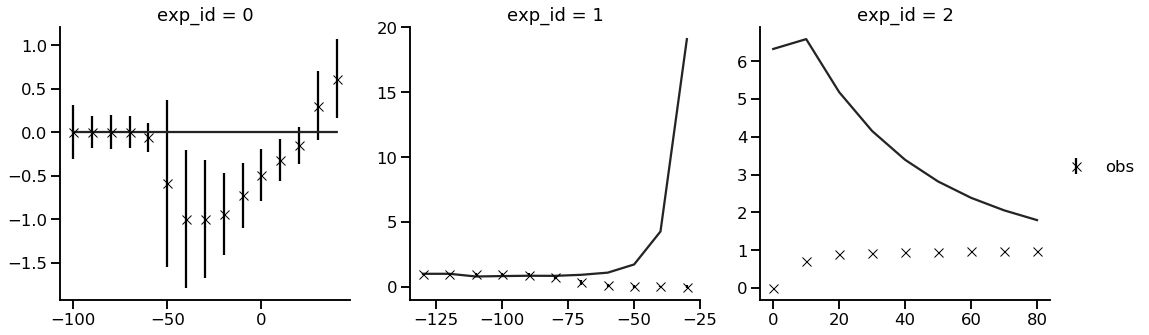

In [6]:
import pandas as pd
results = summary_statistics(model({}))
output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                       'exp_id': observations.exp_id})
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(output, obs=observations)

## Set limits and generate uniform initial priors

In [7]:
from pyabc import Distribution, RV
limits = {'ina.g_Na': (0., 100.),
          'ina.P_Na': (0., 1.),
          'log_ina.p_1': (-7., 3.),
          'ina.p_2': (1e-7, 0.4),
          'log_ina.p_3': (-7., 3.),
          'ina.p_4': (1e-7, 0.4),
          'log_ina.p_5': (-7., 3.),
          'ina.p_6': (1e-7, 0.4),
          'log_ina.p_7': (-7., 3.),
          'ina.p_8': (1e-7, 0.4)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [8]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl1_ina.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl1_ina.db


In [9]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [10]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [11]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(5000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.2219703896069184, '1': 0.3847713811752238, '2': 0.3606021349951203, '3': 0.3847177171053245, '4': 0.41225915881709446, '5': 0.07213551515174561, '6': 0.08743584479666457, '7': 0.10123964662048998, '8': 0.14796835273281753, '9': 0.18615373408322064, '10': 0.23081131550875975, '11': 0.2885231977035901, '12': 0.3205794679115777, '13': 0.17486060422473385, '14': 0.15187061782993855, '15': 1.1776738444210813, '16': 1.0206506651649434, '17': 1.0935542841052994, '18': 0.8505422209707847, '19': 0.900574116322005, '20': 0.6958981807942791, '21': 0.5103253325824705, '22': 0.900574116322005, '23': 0.9568599985921371, '24': 1.7010844419415847, '25': 0.9005741163220135, '26': 2.30730995602202, '27': 2.30730995602202, '28': 2.30730995602202, '29': 2.30730995602202, '30': 2.30730995602202, '31': 2.30730995602202, '32': 2.30730995602202, '33': 2.30730995602202, '34': 2.30730995602202}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [13]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [14]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-07-20 20:03:07.666021, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=200, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 6912
DEBUG:Epsilon:new eps, t=1, eps=4.620631015916385
INFO:ABC:t:1 eps:4.620631015916385
DEBUG:ABC:now submitting population 1


In [ ]:
history = abc.run(minimum_epsilon=0.0, max_nr_populations=100, min_acceptance_rate=0.005)

## Results analysis

In [16]:
from pyabc import History
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2019-07-20 20:03:07.666021, end_time=2019-07-21 15:56:30.862037)>]

In [17]:
history.id = 1
df, w = history.get_distribution(m=0)

In [18]:
df.describe()

name,ina.P_Na,ina.g_Na,ina.p_2,ina.p_4,ina.p_6,ina.p_8,log_ina.p_1,log_ina.p_3,log_ina.p_5,log_ina.p_7
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.733133,25.995968,0.127661,0.039983,0.117970,0.057979,1.831058,-1.966313,1.687710,-3.990659
std,0.018586,20.170602,0.014813,0.057143,0.012523,0.011546,0.520685,1.284869,0.499612,0.603132
min,0.670679,2.746165,0.082076,0.000016,0.082351,0.023651,0.580289,-6.956740,0.524405,-5.840778
25%,0.720579,10.937491,0.116873,0.011714,0.108940,0.050007,1.430150,-2.179387,1.308089,-4.398205
50%,0.732493,19.405565,0.126846,0.020414,0.117315,0.057944,1.813866,-1.606215,1.654542,-3.986863
75%,0.744892,35.443787,0.137583,0.032184,0.126536,0.065743,2.228863,-1.177377,2.046942,-3.575694
max,0.795572,99.946776,0.179717,0.301727,0.159259,0.093267,2.998714,-0.343609,2.999574,-2.191159


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


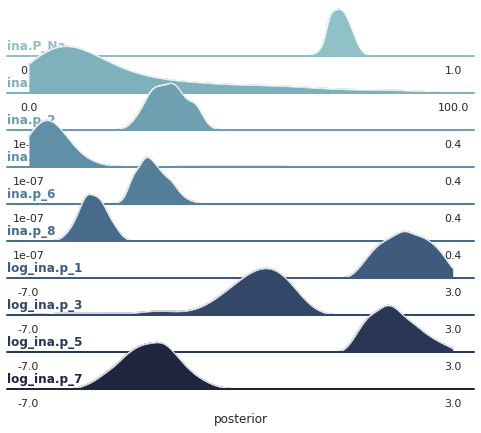

In [19]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [20]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [22]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

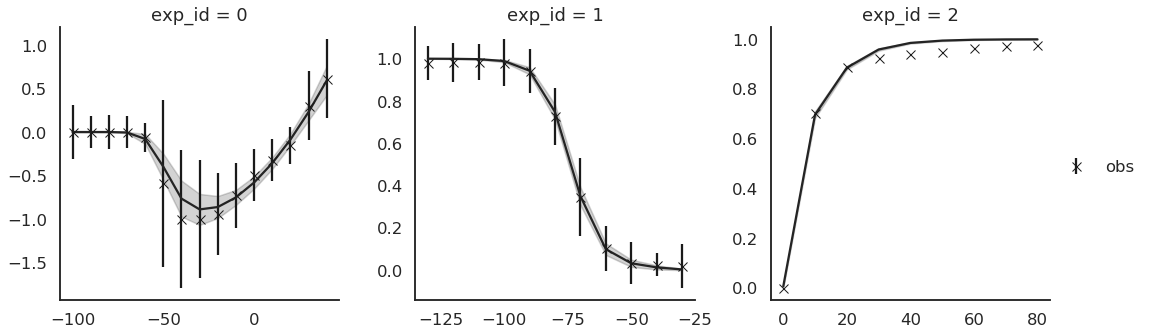

In [23]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=observations)

In [113]:
# Require discrete samples for exact measurements at -20mV
discrete_samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)
    output['sample'] = i
    output['distribution'] = 'post'
    discrete_samples = discrete_samples.append(output, ignore_index=True)

In [114]:
# Amplitude at -20 mV
grouped = discrete_samples[discrete_samples['exp']==0].groupby('sample')
def get_amplitude(group):
    return group.loc[group.x==-20]['y']
print(grouped.apply(get_amplitude).mean())
print(grouped.apply(get_amplitude).std())

-163.74165119888335
0.14129370301730562


In [115]:
import scipy.stats as st
peak_current = discrete_samples[discrete_samples['exp']==0].groupby('sample').apply(get_amplitude).tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -163.81705987307208
95% CI: (-163.85178097293564, -163.4658692841079)


In [116]:
# Voltage and slope factor at half-activation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [117]:
print(output.mean())
print(output.std())

0   -34.955683
1     7.200565
dtype: float64
0    0.015053
1    0.010894
dtype: float64


In [118]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -34.96014346870338
95% CI: (-34.97005619255574, -34.926599614270145)


In [119]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 7.197369620500938
95% CI: (7.19090481887031, 7.224585984649747)


In [120]:
# Voltage and slope factor at half-inactivation
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((V-Vhalf)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [121]:
print(output.mean())
print(output.std())

0   -72.193234
1     6.109548
dtype: float64
0    0.125658
1    0.078064
dtype: float64


In [122]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -72.21669685772069
95% CI: (-72.44020974010718, -71.87864783039117)


In [123]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 6.154343522380662
95% CI: (5.931996934878577, 6.207057392589782)
